# Spatial Networks

## 📖 Ahead of time...

```{margin}
Thank you very much to [Martin Fleischmann](https://martinfleischmann.net/) for providing support and ideas in the development of this block
```

In this block we cover some of the analytics you can obtain when you consider street networks as spatial graphs rather than as geo-tables. 

- A good example of applying concepts and ideas presented in this block is Boeing (2020) {cite}`boeing2020off`
- Boeing (2017) {cite}`boeing_osmnx_2017` provides a general overview on the `osmnx` project
- A brief overview of `momepy`, the package for urban morphometrics, available in Fleischmann (2019) {cite}`fleischmann2019momepy`

## 💻 Hands-on coding

In [1]:
import pandas
import geopandas
import momepy
import networkx as nx
import contextily
import matplotlib.pyplot as plt

````{tabbed} Local files

Assuming you have the file locally on the path `../data/`: 

```python
db = geopandas.read_file("../data/arturo_streets.gpkg")
```
````

````{tabbed} Online read

If you're online, you can do:

```python
db = geopandas.read_file(
    "http://darribas.org/gds4ae/_downloads/67d5480f98453027d59bf49606a7ad92/arturo_streets.gpkg"
)
```
````


In [2]:
db = geopandas.read_file("../data/arturo_streets.gpkg")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


To make things easier later, we "explode" the table so it is made up of `LINESTRINGS` instead of `MULTILINESTRINGS`:

In [3]:
db_tab = db.explode().reset_index()

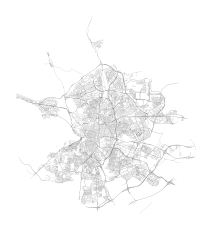

In [4]:
ax = db_tab.plot(
    linewidth=0.05, color="k", figsize=(4, 4)
)
ax.set_axis_off();

In [5]:
db_tab.head()

,level_0,level_1,OGC_FID,dm_id,dist_barri,X,Y,value,geometry
0,0,0,1,1,1606,444133.736820,4.482809e+06,NaN,"LINESTRING (444096.316 4482762.870, 444171.158..."
1,1,0,2,2,1606,444192.038205,4.482878e+06,NaN,"LINESTRING (444212.943 4482901.091, 444199.698..."
2,2,0,3,3,1606,444134.537507,4.482885e+06,NaN,"LINESTRING (444097.968 4482915.826, 444171.158..."
3,3,0,4,4,1603,445612.690578,4.479336e+06,NaN,"LINESTRING (445608.884 4479346.815, 445616.438..."
4,4,0,5,5,1603,445606.319326,4.479354e+06,NaN,"LINESTRING (445603.738 4479362.060, 445608.884..."


### Analysing street geo-tables

#### Length

In [6]:
length = db_tab.to_crs(
    epsg=32630 # Expressed in metres
).geometry.length
length.head()

0    118.699481
1     62.210799
2     95.164472
3     23.503065
4     16.090295
dtype: float64

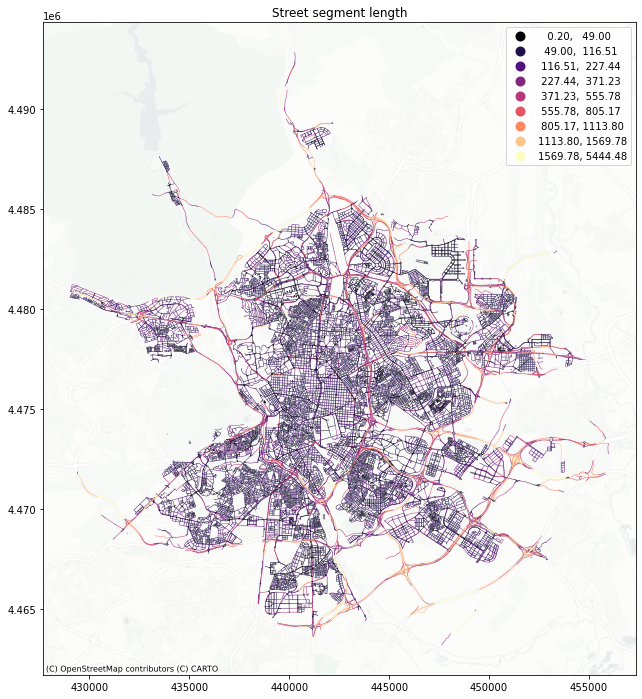

In [7]:
ax = db_tab.assign(
    length=length
).plot(
    "length", 
    scheme="fisherjenkssampled", 
    k=9, 
    legend=True, 
    linewidth=0.5,
    figsize=(12, 12),
    cmap="magma"
)
contextily.add_basemap(
    ax, 
    crs=db_tab.crs, 
    source=contextily.providers.CartoDB.PositronNoLabels,
    alpha=0.5
)
ax.set_title("Street segment length");

#### Linearity

In [8]:
linearity = momepy.Linearity(db_tab).series
linearity.head()

0    1.000000
1    0.999999
2    1.000000
3    1.000000
4    1.000000
dtype: float64

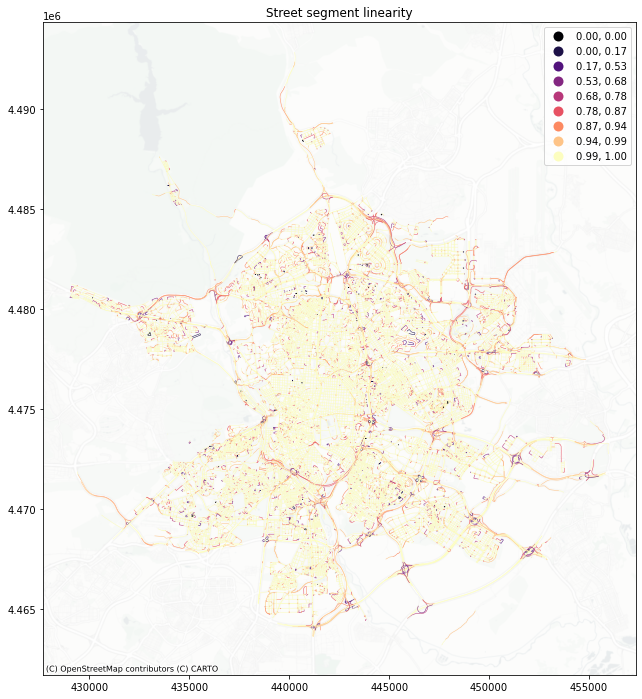

In [9]:
ax = db_tab.assign(
    linearity=linearity
).plot(
    "linearity", 
    scheme="fisherjenkssampled", 
    k=9, 
    legend=True, 
    linewidth=0.5,
    figsize=(12, 12),
    cmap="magma"
)
contextily.add_basemap(
    ax, 
    crs=db_tab.crs, 
    source=contextily.providers.CartoDB.PositronNoLabels,
    alpha=0.5
)
ax.set_title("Street segment linearity");

### Streets as spatial graphs

From geo-table to spatial graph:

In [10]:
db_graph = momepy.gdf_to_nx(db_tab)

db_graph

Now `db_graph` is a different animal than `db` that emphasizes *connections* rather than observation attributes.

In [11]:
db_graph.is_directed()

False

In [12]:
db_graph.is_multigraph()

True

The (first and last) coordinates of each street segment become the ID for each segment in the graph:

In [13]:
print(db_tab.loc[0, "geometry"])

LINESTRING (444096.3161762458 4482762.870216271, 444171.158127317 4482855.001910598)


In [14]:
l = db_tab.loc[0, "geometry"]
l.coords

In [15]:
node0a, node0b = edge0 = list(
    db_tab.loc[0, "geometry"].coords
)
edge0

[(444096.3161762458, 4482762.870216271),
 (444171.15812731703, 4482855.001910598)]

We can use those to extract adjacencies to each node:

In [16]:
db_graph[node0a]

AdjacencyView({(444171.15812731703, 4482855.001910598): {0: {'level_0': 0, 'level_1': 0, 'OGC_FID': '1', 'dm_id': '1', 'dist_barri': '1606', 'X': 444133.736820226, 'Y': 4482808.89166328, 'value': nan, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f88b3e34a00>, 'mm_len': 118.69948078964639}}, (444083.8275243509, 4482747.422611062): {538: {'level_0': 538, 'level_1': 0, 'OGC_FID': '539', 'dm_id': '539', 'dist_barri': '1606', 'X': 444090.105664431, 'Y': 4482755.13506047, 'value': nan, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f88b43281c0>, 'mm_len': 19.864413729824115}}})

We can access edge information for each pair of nodes with a concatenated dict query:

In [17]:
db_graph[node0a][node0b]

AtlasView({0: {'level_0': 0, 'level_1': 0, 'OGC_FID': '1', 'dm_id': '1', 'dist_barri': '1606', 'X': 444133.736820226, 'Y': 4482808.89166328, 'value': nan, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f88b3e34a00>, 'mm_len': 118.69948078964639}})

In [18]:
db_graph[node0a][node0b][0]

{'level_0': 0,
 'level_1': 0,
 'OGC_FID': '1',
 'dm_id': '1',
 'dist_barri': '1606',
 'X': 444133.736820226,
 'Y': 4482808.89166328,
 'value': nan,
 'geometry': <shapely.geometry.linestring.LineString at 0x7f88b3e34a00>,
 'mm_len': 118.69948078964639}

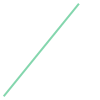

In [19]:
db_graph[node0a][node0b][0]["geometry"]

If we need all the node IDs:

In [20]:
list(
    db_graph.nodes
)[:5] # Limit to the first five elements

[(444096.3161762458, 4482762.870216271),
 (444171.15812731703, 4482855.001910598),
 (444212.942998509, 4482901.090971609),
 (444097.96831143444, 4482915.825653204),
 (445608.8837672261, 4479346.814511424)]

And same for edges:

````{margin}
```{note}
`edges` returns a triplet with the origin and destination node IDs, *and* the ID of the edge, which is linked to the ID of the segment in the geo-table
```
````

In [21]:
list(
    db_graph.edges
)[:5] # Limit to the first five elements

[((444096.3161762458, 4482762.870216271),
  (444171.15812731703, 4482855.001910598),
  0),
 ((444096.3161762458, 4482762.870216271),
  (444083.8275243509, 4482747.422611062),
  538),
 ((444171.15812731703, 4482855.001910598),
  (444212.942998509, 4482901.090971609),
  1),
 ((444171.15812731703, 4482855.001910598),
  (444097.96831143444, 4482915.825653204),
  2),
 ((444212.942998509, 4482901.090971609),
  (444254.9705938099, 4482866.143285849),
  10886)]

Or:

In [22]:
db_graph.edges[node0a, node0b, 0]

{'level_0': 0,
 'level_1': 0,
 'OGC_FID': '1',
 'dm_id': '1',
 'dist_barri': '1606',
 'X': 444133.736820226,
 'Y': 4482808.89166328,
 'value': nan,
 'geometry': <shapely.geometry.linestring.LineString at 0x7f88b3e34a00>,
 'mm_len': 118.69948078964639}

If you want fast access to adjacencies:

In [23]:
db_graph.adj[node0a]

AdjacencyView({(444171.15812731703, 4482855.001910598): {0: {'level_0': 0, 'level_1': 0, 'OGC_FID': '1', 'dm_id': '1', 'dist_barri': '1606', 'X': 444133.736820226, 'Y': 4482808.89166328, 'value': nan, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f88b3e34a00>, 'mm_len': 118.69948078964639}}, (444083.8275243509, 4482747.422611062): {538: {'level_0': 538, 'level_1': 0, 'OGC_FID': '539', 'dm_id': '539', 'dist_barri': '1606', 'X': 444090.105664431, 'Y': 4482755.13506047, 'value': nan, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f88b43281c0>, 'mm_len': 19.864413729824115}}})

### Analysing graphs

There are _many_ ways to extract information and descriptives from a graph. In this section we will explore a few that can tell us important information about the position of a node or edge in the network and about the broader characteristics of sections of the graph.

#### Degree

Degree tells us the number of neighbors of every edge, that is how many other nodes it is directly connected to.

In [24]:
degree = list(db_graph.degree)
degree[:5]

[((444096.3161762458, 4482762.870216271), 2),
 ((444171.15812731703, 4482855.001910598), 3),
 ((444212.942998509, 4482901.090971609), 3),
 ((444097.96831143444, 4482915.825653204), 3),
 ((445608.8837672261, 4479346.814511424), 2)]

#### Node centrality

Fraction of nodes a node is connected to:

In [25]:
nc = pandas.Series(
    nx.degree_centrality(db_graph)
)
nc.head()

444096.316176  4.482763e+06    0.00004
444171.158127  4.482855e+06    0.00006
444212.942999  4.482901e+06    0.00006
444097.968311  4.482916e+06    0.00006
445608.883767  4.479347e+06    0.00004
dtype: float64

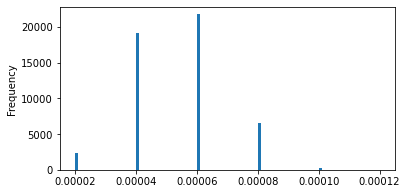

In [26]:
nc.plot.hist(bins=100, figsize=(6, 3));

```{tip}
Other variations of centrality measures are available in `networkx`. The are computationally demanding but relatively straightforward to calculate using the library. For a few of those, you can check:

- [This `networkx` example](https://networkx.org/documentation/stable/auto_examples/algorithms/plot_krackhardt_centrality.html#sphx-glr-auto-examples-algorithms-plot-krackhardt-centrality-py)
- [The `momepy` documentation on centrality](http://docs.momepy.org/en/stable/user_guide/graph/centrality.html#Closeness-centrality)
```

#### Meshedness

The [messedness](http://docs.momepy.org/en/stable/generated/momepy.meshedness.html#momepy.meshedness) of a graph captures the degree of node edge density as compared to that of nodes. Higher meshedness is related to denser, more inter-connected grids.

In [27]:
%time meshd = momepy.meshedness(db_graph, distance=500)

100%|██████████| 49985/49985 [00:57<00:00, 876.55it/s] 

CPU times: user 57.8 s, sys: 132 ms, total: 57.9 s
Wall time: 57.8 s


In [28]:
meshd.nodes[node0a]

{'meshedness': 0.058823529411764705}

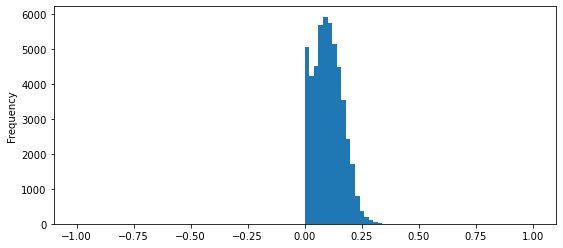

In [29]:
pandas.Series(
    {i: meshd.nodes[i]["meshedness"] for i in meshd.nodes}
).plot.hist(bins=100, figsize=(9, 4));

### Attaching information to street segments



The trick here is to be able to transfer back the information stored as graphs into geo-tables so we can apply everything we already now about manipulating and mapping data in that structure. With `momepy`, we can bring a graph back into a geo-table:

In [30]:
nodes = momepy.nx_to_gdf(
    meshd, points=True, lines=False
)

In [31]:
nodes.head()

,meshedness,nodeID,geometry
0,0.058824,1,POINT (444096.316 4482762.870)
1,0.092308,2,POINT (444171.158 4482855.002)
2,0.101449,3,POINT (444212.943 4482901.091)
3,0.065574,4,POINT (444097.968 4482915.826)
4,0.000000,5,POINT (445608.884 4479346.815)


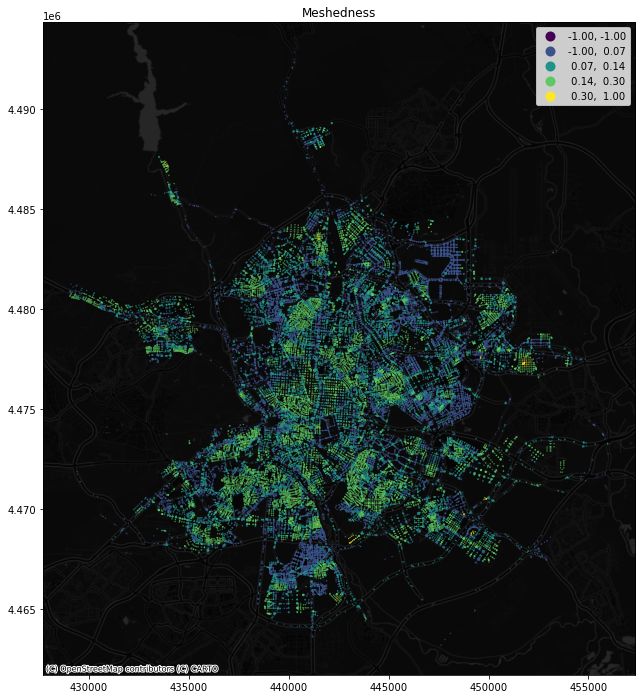

In [32]:
ax = nodes.plot(
    "meshedness", 
    scheme="fisherjenkssampled",
    markersize=0.1,
    legend=True, 
    figsize=(12, 12)
)
contextily.add_basemap(
    ax, 
    crs=nodes.crs,
    source=contextily.providers.CartoDB.DarkMatterNoLabels
)
ax.set_title("Meshedness");

With other measures index on node IDs, we can use joining machinery in `pandas`:

In [33]:
nc.head()

444096.316176  4.482763e+06    0.00004
444171.158127  4.482855e+06    0.00006
444212.942999  4.482901e+06    0.00006
444097.968311  4.482916e+06    0.00006
445608.883767  4.479347e+06    0.00004
dtype: float64

In [34]:
degree_tab = pandas.DataFrame(
    degree, columns=["id", "degree"]
)
degree_tab.index = pandas.MultiIndex.from_tuples(
    degree_tab["id"]
)
degree_tab = degree_tab["degree"]
degree_tab.head()

444096.316176  4.482763e+06    2
444171.158127  4.482855e+06    3
444212.942999  4.482901e+06    3
444097.968311  4.482916e+06    3
445608.883767  4.479347e+06    2
Name: degree, dtype: int64

In [35]:
net_stats = pandas.DataFrame(
    {"degree": degree_tab, "centrality": nc},
)
net_stats.index.names = ["x", "y"]
net_stats.head()

,,degree,centrality
x,y,,
444096.316176,4.482763e+06,2,0.00004
444171.158127,4.482855e+06,3,0.00006
444212.942999,4.482901e+06,3,0.00006
444097.968311,4.482916e+06,3,0.00006
445608.883767,4.479347e+06,2,0.00004


In [36]:
net_stats_geo = nodes.assign(
    x=nodes.geometry.x
).assign(
    y=nodes.geometry.y
).set_index(
    ["x", "y"]
).join(net_stats)

net_stats_geo.head()

,,meshedness,nodeID,geometry,degree,centrality
x,y,,,,,
444096.316176,4.482763e+06,0.058824,1,POINT (444096.316 4482762.870),2,0.00004
444171.158127,4.482855e+06,0.092308,2,POINT (444171.158 4482855.002),3,0.00006
444212.942999,4.482901e+06,0.101449,3,POINT (444212.943 4482901.091),3,0.00006
444097.968311,4.482916e+06,0.065574,4,POINT (444097.968 4482915.826),3,0.00006
445608.883767,4.479347e+06,0.000000,5,POINT (445608.884 4479346.815),2,0.00004


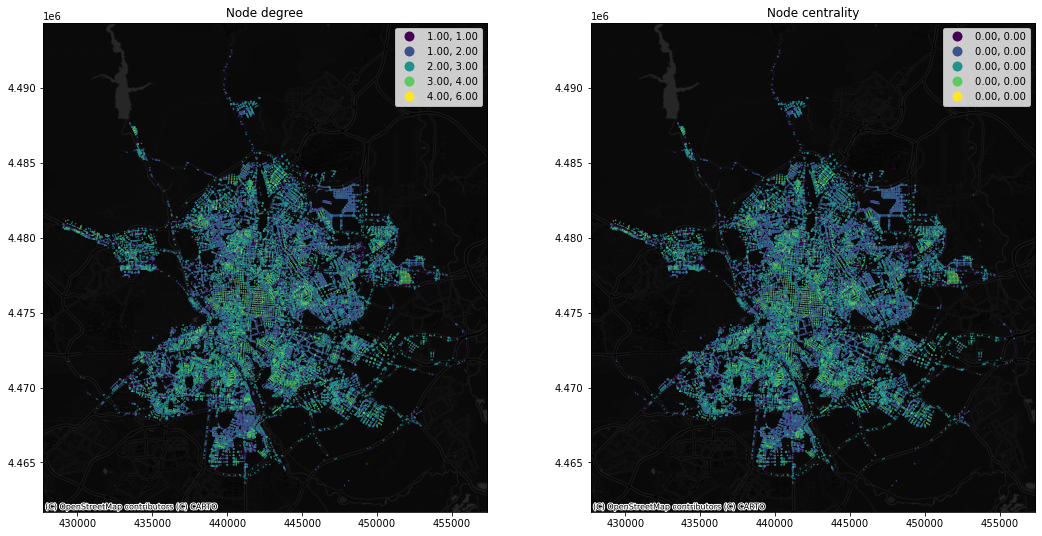

In [37]:
f, axs = plt.subplots(1, 2, figsize=(18, 9))
vars_to_plot = ["degree", "centrality"]
for i in range(2):
    net_stats_geo.plot(
        vars_to_plot[i], 
        scheme="fisherjenkssampled",
        markersize=0.2,
        legend=True, 
        ax=axs[i]
    )
    contextily.add_basemap(
        axs[i], 
        crs=nodes.crs,
        source=contextily.providers.CartoDB.DarkMatterNoLabels
    )
    axs[i].set_title(f"Node {vars_to_plot[i]}")

## 🐾 Next steps

If you found the content in this block useful, the following resources represent some suggestions on where to go next:

- The [NetworkX tutorial](https://networkx.org/documentation/stable/tutorial.html) is a great place to get a better grasp of the data structures we use to represent (spatial) graphs
- Parts of the block benefit from the section on [urban networks](https://github.com/gboeing/ppd599/blob/master/modules/07-urban-networks-i/lecture.ipynb) in Geoff Boeing's excellent [course on Urban Data Science](https://github.com/gboeing/ppd599)
- If you are interested in urban morphometric analysis (the study of the shape of different elements making up cities), the [`momepy`](http://docs.momepy.org/en/stable/) library is an excellent reference to absorb, including its [user guide](http://docs.momepy.org/en/stable/user_guide/intro.html)
